In [4496]:
# ! pip install stockstats

In [4497]:
# ! pip install pandas-ta

In [4498]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import math as mt
import stockstats
import warnings
warnings.filterwarnings('ignore')
import pandas_ta as ta

In [4499]:
# def calculate_bollinger_bands(data, BBANDS_window, STDDEV_factor):

#     weights = np.arange(1, BBANDS_window + 1)
#     weights_sum = np.sum(weights)
#     middle_band = np.convolve(data['HA_CLOSE'], weights[::-1], mode='valid') / weights_sum
#     middle_band = np.pad(middle_band, (len(data) - len(middle_band), 0), 'constant', constant_values=np.nan)
#     data['MiddleBand'] = middle_band


#     deviations = data['HA_CLOSE'] - data['MiddleBand']


#     squared_deviations = deviations ** 2
#     sum_squared_deviations = np.convolve(squared_deviations, np.ones(BBANDS_window), mode='valid')
#     std = np.sqrt(sum_squared_deviations / (BBANDS_window - 1))
#     std = np.pad(std, (len(data) - len(std), 0), 'constant', constant_values=np.nan)
#     data['Std'] = std


#     data['UpperBand'] = data['MiddleBand'] + STDDEV_factor * data['Std']
#     data['LowerBand'] = data['MiddleBand'] - STDDEV_factor * data['Std']

#     return data


In [4500]:
# dfb = pd.read_csv('data_2020_2023_3min_heikin.csv')
# dfb = calculate_bollinger_bands(dfb, 15, 2)
# dfb['datetime'] = pd.to_datetime(dfb['datetime'])
# dfb.set_index('datetime', inplace=True)
# df_hourly = dfb[dfb.index.minute == 30]
# df_hourly.reset_index(inplace=True)

In [4501]:
df = pd.read_csv(r'C:\Users\harsh\OneDrive\Desktop\PROJECTS\ZELTA\csv\data_2020_2023_1h.csv')

## HEIKIN-ASHI CANDELSTICKS

In [4502]:
def heikin_ashi_candlesticks(df: pd.DataFrame):
    # Calculate HA close
    df["HA_CLOSE"] = (df["low"] + df["high"] + df["close"] + df["open"]) / 4

    for i in range(len(df)):
            if i == 0:
                # For the first row
                df.at[i, "HA_OPEN"] = (df.at[i, "open"] + df.at[i, "close"]) / 2
            else:
                # For subsequent rows
                df.at[i, "HA_OPEN"] = (df.at[i - 1, "HA_OPEN"] + df.at[i - 1, "HA_CLOSE"]) / 2

    df["HA_HIGH"] = df[["HA_OPEN", "HA_CLOSE", "high"]].max(axis=1)
    df["HA_LOW"] = df[["HA_OPEN", "HA_CLOSE", "low"]].min(axis=1)

    return df

In [4503]:
df = heikin_ashi_candlesticks(df)

## ATR


In [4504]:
df['ATR'] = ta.atr(df['high'], df['low'], df['close'], length= 6)
# df['ATR'] = df.ATR.ewm(span=20, adjust=False).mean()

## MACD

**MACD NORMAL**

In [4505]:
def macd(df):
    
    df['MACD'] = df['HA_CLOSE'].ewm(span = 12,adjust=False).mean() - df['HA_CLOSE'].ewm(span=28,adjust=False).mean()
    df['Signal_MACD'] = df['MACD'].ewm(span = 9,adjust = False).mean()
    return df
df = macd(df)

df ['IBS'] = (df['HA_CLOSE'] - df['HA_LOW']) /(df['HA_HIGH'] - df['HA_LOW'])
df['weight_avg'] = df['IBS'].ewm(span=5,adjust=True).mean()

**VOLATLITY MACD**

In [4506]:
def macd_v(df):
    
    df['MACD_V'] = df['HA_CLOSE'].ewm(span = 18,adjust=False).mean() - df['HA_CLOSE'].ewm(span=40,adjust=False).mean()
    df['Signal_MACD_V'] = df['MACD_V'].ewm(span = 12,adjust = False).mean()
    return df
df = macd_v(df)

# df ['IBS'] = (df['close'] - df['low']) /(df['high'] - df['low'])
df['weight_avg_V'] = df['IBS'].ewm(span=4,adjust=True).mean()

In [4507]:
np.min(df.weight_avg)

0.2778089412834825

In [4508]:
signal = []
for i in range(len(df)):
  if(df.ATR[i] <= 650):
    if(df['MACD'][i] > df['Signal_MACD'][i] and df['MACD'][i-1] < df['Signal_MACD'][i-1]):
      signal.append(1)
    elif(df['MACD'][i] < df['Signal_MACD'][i] and df['MACD'][i-1] > df['Signal_MACD'][i-1]):
      signal.append(-1)
    else:
      signal.append(0)
  elif(df.ATR[i] > 650):
    if(df['MACD_V'][i] > df['Signal_MACD_V'][i] and df['MACD_V'][i-1] < df['Signal_MACD_V'][i-1]):
      signal.append(1)
    elif(df['MACD_V'][i] < df['Signal_MACD_V'][i] and df['MACD_V'][i-1] > df['Signal_MACD_V'][i-1]):
      signal.append(-1)
    else:
      signal.append(0)
  else:
    signal.append(0)
    
df['signals_macd'] = signal


In [4509]:
np.max(df['weight_avg_V'])

0.7749121920027403

## ADX

In [4510]:
def include_adx(df ,adx_period):
    ad = ta.adx(df['HA_HIGH'] , df['HA_LOW'] , df['HA_CLOSE'] , timeperiod=adx_period)
    # df['+di'] = ta.plus_di(df['HA_HIGH'] , df['HA_LOW'] , df['HA_CLOSE'] , timeperiod= di_period)
    # df['-di'] = ta.MINUS_DI(df['HA_HIGH'] , df['HA_LOW'] , df['HA_CLOSE'] , timeperiod= di_period)

    df['ADX'] = ad['ADX_14']
    df['+DI'] = ad['DMP_14']
    df['-DI'] = ad['DMN_14']
    return df

In [4511]:
df = include_adx(df, 14)

In [4512]:
signal = []
for i in range(len(df)):
  if(df['+DI'][i] > df['-DI'][i] and df['ADX'][i] >= 25):
    signal.append(1)
  elif(df['+DI'][i] < df['-DI'][i] and df['ADX'][i] >= 25):
    signal.append(-1)
  else:
    signal.append(0)
df['signals_adx'] = signal

## ICHIMOKU CLOUDS

In [4513]:
def ichimoku_cloud(
    data: pd.DataFrame,
    small_period: int =7,
    large_period: int = 42,
    rolling_period: int = 60,
):

    small_period_high = data["HA_HIGH"].rolling(window=small_period).max()
    small_period_low = data["HA_LOW"].rolling(window=small_period).min()
    data["tenkan_sen"] = (small_period_high + small_period_low) / 2

    large_period_high = data["HA_HIGH"].rolling(window=large_period).max()
    large_period_low = data["HA_LOW"].rolling(window=large_period).min()
    data["kijun_sen"] = (large_period_high + large_period_low) / 2

    data["senkou_span_a"] = (data["tenkan_sen"] + data["kijun_sen"]) / 2
    data["senkou_span_a"] = data["senkou_span_a"].shift(20)
    data["senkou_span_b"] = (
        data["HA_HIGH"].rolling(window=rolling_period).max()
        + data["HA_LOW"].rolling(window=rolling_period).min()
    ) / 2
    data["senkou_span_b"] = data["senkou_span_b"].shift(40)
    return data

In [4514]:
df = ichimoku_cloud(df)

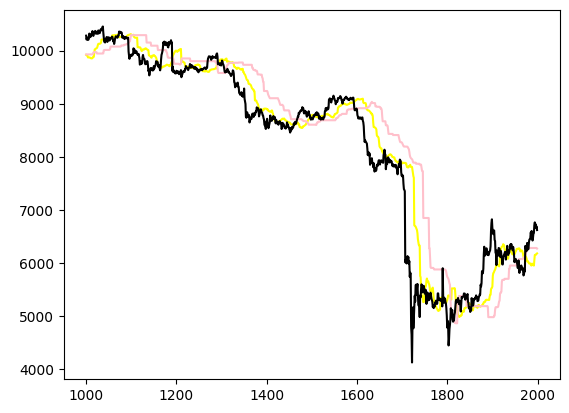

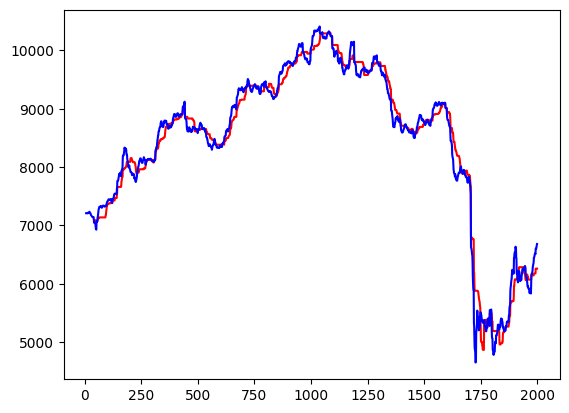

In [4515]:
y_1 = df['senkou_span_a'][1000:2000]
y_2 = df['senkou_span_b'][1000:2000]
y = df['close'][1000:2000]
x = df.index[1000:2000]
plt.plot(x,y_1, color = 'yellow')
plt.plot(x,y_2, color = 'pink')
plt.plot(x,y, color = 'black')

plt.figure()
y_1 = df['kijun_sen'][0:2000]
y_2 = df['tenkan_sen'][0:2000]
x = df.index[0:2000]
plt.plot(x,y_1, color = 'red')
plt.plot(x,y_2, color = 'blue')


In [4516]:
cloud_upper_bound = []
cloud_lower_bound = []
cloud_width = []
df['cloud_threshold'] = 0
for i in range(len(df)):
    
    cloud_width.append(abs(df['senkou_span_a'][i] - df['senkou_span_b'][i]))
    cloud_upper_bound.append(max(df['senkou_span_a'][i],df['senkou_span_b'][i]))
    cloud_lower_bound.append(min(df['senkou_span_a'][i],df['senkou_span_b'][i]))
    df['cloud_threshold'][i] = (cloud_upper_bound[-1] - cloud_lower_bound[-1])
cloud_threshold = df['cloud_threshold'].rolling(window=11).mean()

In [4517]:
## Signals based on cloud width 

signal = []
for i in range(len(df)):
    
    if(df['HA_CLOSE'][i] > cloud_upper_bound[i]  and cloud_width[i] > 2*cloud_threshold[i]):
        signal.append(1)
    elif(df['HA_CLOSE'][i] < cloud_lower_bound[i]  and cloud_width[i] > 2*cloud_threshold[i]):
        signal.append(-1)
    else:
        signal.append(0)
df['signal_ich_1'] = signal

## Bearish and bullish market signals

signal = []
for i in range(len(df)):
    if(df['tenkan_sen'][i] > df['kijun_sen'][i] and df['tenkan_sen'][i-1] < df['kijun_sen'][i-1]):
        signal.append(1)
    elif(df['tenkan_sen'][i] < df['kijun_sen'][i] and df['tenkan_sen'][i-1] > df['kijun_sen'][i-1]):
        signal.append(-1)
    else:
        signal.append(0)
df['signal_ich_2'] = signal

## Another way of genrating signals

signal = []
for i in range(len(df)):
    if(df.HA_CLOSE[i] > df.senkou_span_a[i] and df.senkou_span_a[i] > df.senkou_span_b[i]):
        signal.append(1)
    elif(df.HA_CLOSE[i] < df.senkou_span_a[i] and df.senkou_span_a[i] > df.senkou_span_b[i]):
        signal.append(-1)
    else:
        signal.append(0)
df['signal_ich_3'] = signal

In [4518]:
# df['senkou_span_a'] - df['senkou_span_b']

## sma


In [4519]:
df['sma_20'] = df['HA_CLOSE'].ewm(span=17,adjust=False).mean()

## hulu

In [4520]:
def hma(data,period):
 wma_1 = data['HA_CLOSE'].rolling(period//2).apply(lambda x: \
 np.sum(x * np.arange(1, period//2+1)) / np.sum(np.arange(1, period//2+1)), raw=True)
 wma_2 = data['HA_CLOSE'].rolling(period).apply(lambda x: \
 np.sum(x * np.arange(1, period+1)) / np.sum(np.arange(1, period+1)), raw=True)
 diff = 2 * wma_1 - wma_2
 hma = diff.rolling(int(np.sqrt(period))).mean()
 data['hma'] = hma
 return data

In [4521]:
df = hma(df, 25)

In [4522]:
signal = []
for i in range(len(df)):
    if(df['hma'][i] > df['sma_20'][i]):
        signal.append(1)
    elif(df['hma'][i] < df['sma_20'][i]):
        signal.append(-1)
    else:
        signal.append(0)
df['signal_hma'] = signal

## BOLLINGER BANDS


In [4523]:
def calculate_bollinger_bands(data, BBANDS_window, STDDEV_factor):

    weights = np.arange(1, BBANDS_window + 1)
    weights_sum = np.sum(weights)
    middle_band = np.convolve(data['HA_CLOSE'], weights[::-1], mode='valid') / weights_sum
    middle_band = np.pad(middle_band, (len(data) - len(middle_band), 0), 'constant', constant_values=np.nan)
    data['MiddleBand'] = middle_band


    deviations = data['HA_CLOSE'] - data['MiddleBand']


    squared_deviations = deviations ** 2
    sum_squared_deviations = np.convolve(squared_deviations, np.ones(BBANDS_window), mode='valid')
    std = np.sqrt(sum_squared_deviations / (BBANDS_window - 1))
    std = np.pad(std, (len(data) - len(std), 0), 'constant', constant_values=np.nan)
    data['Std'] = std


    data['UpperBand'] = data['MiddleBand'] + STDDEV_factor * data['Std']
    data['LowerBand'] = data['MiddleBand'] - STDDEV_factor * data['Std']

    return data


In [4524]:
calculate_bollinger_bands(df,15, 2.8)

,datetime,open,high,low,close,volume,HA_CLOSE,HA_OPEN,HA_HIGH,HA_LOW,...,signal_ich_1,signal_ich_2,signal_ich_3,sma_20,hma,signal_hma,MiddleBand,Std,UpperBand,LowerBand
0,2020-01-01 05:30:00,7195.24,7196.25,7175.46,7177.02,511.814901,7185.9925,7186.130000,7196.250000,7175.460000,...,0,0,0,7185.992500,NaN,0,NaN,NaN,NaN,NaN
1,2020-01-01 06:30:00,7176.47,7230.00,7175.71,7216.27,883.052603,7199.6125,7186.061250,7230.000000,7175.710000,...,0,0,0,7187.505833,NaN,0,NaN,NaN,NaN,NaN
2,2020-01-01 07:30:00,7215.52,7244.87,7211.41,7242.85,655.156809,7228.6625,7192.836875,7244.870000,7192.836875,...,0,0,0,7192.078796,NaN,0,NaN,NaN,NaN,NaN
3,2020-01-01 08:30:00,7242.66,7245.00,7220.00,7225.01,783.724867,7233.1675,7210.749687,7245.000000,7210.749687,...,0,0,0,7196.644208,NaN,0,NaN,NaN,NaN,NaN
4,2020-01-01 09:30:00,7225.00,7230.00,7215.03,7217.27,467.812578,7221.8250,7221.958594,7230.000000,7215.030000,...,0,0,0,7199.442074,NaN,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35028,2024-01-01 01:30:00,42619.04,42680.36,42504.56,42558.01,1015.140350,42590.4925,42615.763510,42680.360000,42504.560000,...,0,0,0,42496.924497,42638.191108,1,42562.401688,158.599534,43006.480381,42118.322994
35029,2024-01-01 02:30:00,42558.02,42670.44,42520.72,42520.72,923.438130,42567.4750,42603.128005,42670.440000,42520.720000,...,0,0,0,42504.763442,42643.412084,1,42566.735146,158.599657,43010.814185,42122.656107
35030,2024-01-01 03:30:00,42520.73,42591.10,42056.00,42257.88,1811.594110,42356.4275,42585.301502,42591.100000,42056.000000,...,0,0,0,42488.281670,42633.644588,1,42541.889083,158.839820,42986.640578,42097.137588
35031,2024-01-01 04:30:00,42257.89,42345.65,42066.00,42283.58,1710.137210,42238.2800,42470.864501,42470.864501,42066.000000,...,0,0,0,42460.503707,42604.761067,1,42502.919854,164.342447,42963.078706,42042.761003


In [4525]:
signal = []
for i in range(len(df)):
    if(df.HA_CLOSE[i] > df.UpperBand[i] and df.HA_CLOSE[i-1] < df.UpperBand[i-1]):
        signal.append(1)
    elif(df.HA_CLOSE[i] < df.LowerBand[i] and df.HA_CLOSE[i-1] > df.LowerBand[i-1]):
        signal.append(-1)
    else:
        signal.append(0)
df['signal_bollinger'] = signal

## Supertrend


In [4526]:
# # Function to calculate SuperTrend
# def calculate_super_trend(data, atr_period, multiplier):
#     # Calculate the average of high and low prices
#     high_low_avg = (data['high'] + data['low']) / 2

#     # Calculate the True Range (TR)
#     data['tr'] = data['high'] - data['low']

#     # Calculate the Average True Range (ATR) using rolling mean
#     data['atr'] = data['tr'].rolling(atr_period).mean()

#     # Calculate the upper and lower bands of the SuperTrend
#     data['upper_band'] = high_low_avg + multiplier * data['atr']
#     data['lower_band'] = high_low_avg - multiplier * data['atr']

#     # Initialize a column to track whether the market is in an uptrend
#     data['in_uptrend'] = True

#     # Loop through the data to determine the trend direction
#     for i in range(1, len(data)):
#         # Check if the previous close was above the upper band
#         if data['close'][i - 1] > data['upper_band'][i - 1]:
#             data['in_uptrend'][i] = False
#         # Check if the previous close was below the lower band
#         elif data['close'][i - 1] < data['lower_band'][i - 1]:
#             data['in_uptrend'][i] = True
#         else:
#             # If neither, maintain the previous trend direction
#             data['in_uptrend'][i] = data['in_uptrend'][i - 1]

#         # Adjust the bands based on the trend direction
#         if data['in_uptrend'][i]:
#             data['lower_band'][i] = max(data['lower_band'][i], data['lower_band'][i - 1])
#         else:
#             data['upper_band'][i] = min(data['upper_band'][i], data['upper_band'][i - 1])

#     # Create a 'SuperTrend' column based on the trend direction
#     data['SuperTrend'] = np.where(data['in_uptrend'], data['lower_band'], data['upper_band'])

#     # Return a DataFrame containing only the 'SuperTrend' column
#     return data[['SuperTrend']]

# # Calculate SuperTrend using the defined function
# df['super'] = calculate_super_trend(df, 12, 4)

# # Initialize a 'trend' column in the DataFrame
# df['trend'] = 0

# # Determine the trend direction based on the relationship between 'close' and 'super'
# for i in range(len(df)):
#     if df.close[i] > df.super[i]:
#         df.trend[i] = 1  # Set trend to 1 for an uptrend
#     elif df.close[i] < df.super[i]:
#         df.trend[i] = -1  # Set trend to -1 for a downtrend

In [4527]:
# df['st'] = df.trend.rolling(window = 25).mean()

In [4528]:
df['log'] = 0
for i in range(1,len(df)):
    damn = mt.log(df.close[i]/df.close[i-1])
    df.log[i] = damn
df['slope'] = df.log.rolling(window = 5).mean()
df['log slope'] = (df['slope'][i] - df['slope'].shift(10))/10

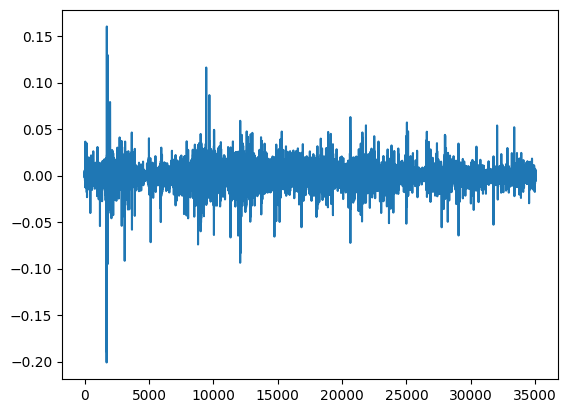

In [4529]:
y = df.log
x = df.index
plt.plot(x,y)

## FINAL SIGNALS

In [4530]:
signal = []
for i in range(len(df)):
  ads = df['signals_adx'][i]
  ms = df['signals_macd'][i]
  ichs_1 = df['signal_ich_1'][i]
  ichs_2 = df['signal_ich_2'][i]
  ichs_3 = df['signal_ich_3'][i]
  hms = df.signal_hma[i]
  slope = df['log slope'][i]
  IBS = df['IBS'][i]
  bs = df['signal_bollinger'][i]
  # super_trend = df.trend[i]
  # if(ms + ichs >= 2):
  # if(ichs_1 + ichs_2 + ads + ms >=3):
  # if(ichs_1 + ichs_2 + ichs_3 >= 2 and ms + hms + ads >= 2):
  if(bs + ads >= 2 and df.ATR[i] <= 1000):
    signal.append(1)
  # elif(ms + ichs <= -2):
  # elif(ichs_1 + ichs_2 + ichs_3 <= -2 and ms + hms + ads <= -2 ):
  elif(bs + ads <= -2 and df['ATR'][i] <= 900):
    signal.append(-1)
  else:
    signal.append(0)
df['signals_bs'] = signal

In [4531]:
signal = []
for i in range(len(df)):
  ads = df['signals_adx'][i]
  ms = df['signals_macd'][i]
  ichs_1 = df['signal_ich_1'][i]
  ichs_2 = df['signal_ich_2'][i]
  ichs_3 = df['signal_ich_3'][i]
  hms = df.signal_hma[i]
  slope = df['log slope'][i]
  IBS = df['IBS'][i]
  bs = df['signal_bollinger'][i]
  # super_trend = df.trend[i]
  # if(ms + ichs >= 2):
  # if(ichs_1 + ichs_2 + ads + ms >=3):
  if(ichs_1 + ichs_2 + ichs_3 >= 2 and  hms + ads >= 2):
#   if(bs + ads >= 2):
    signal.append(1)
  # elif(ms + ichs <= -2):
  elif(ichs_1 + ichs_2 + ichs_3 <= -2 and  hms + ads <= -2 ):
#   elif(bs + ads <= -2):
    signal.append(-1)
  else:
    signal.append(0)
df['signals_ich'] = signal

## BACKTESTING

In [4532]:
def backtest_1(data, signal, n,stop_loss_percent=0.02,dynamic_exit_percent=0.3,multi_long = 2.5, multi_short = 0.21):
    current=0 #what position you are having
    capital=1000
    entry=[]
    exit=[]
    number_of_stock=0
    type_of_trade=[]
    duration=[]
    win=0
    stop_loss=0
    dynamic_exit=0
    loss=0
    count_stop_loss=0
    count_dynamic_exit=0
    current_maxima=0
    current_minima=0
    multiplier=1
    signals = []
    portfolio_value=[] #total capital-> non investment+ investment
    pl=[] # profit and loss
    for i in range(len(data)-1):
        if(current==1):
            if(signal[i]==1 or signal[i]==0):
                capital=capital+(number_of_stock*data.close[i])
                portfolio_value.append(capital)
                jump = (data['close'][i] - data['close'][i-1])*100/data['close'][i-1]
                # if(capital<=stop_loss or capital <= atr_stop_loss or jump >= 7.9):
                if(data['close'][i] <=stop_loss or data.close[i] <= atr_stop_loss or jump >= 4.57):
                    returns = (capital - invested_capital)*100/invested_capital
                    count_stop_loss=count_stop_loss+1
                    exit.append(i)
                    signals.append(-1)
                    current=0
                    duration.append(exit[-1]-entry[-1])
                    x=portfolio_value[exit[-1]]-portfolio_value[entry[-1]]
                    pl.append(x)
                    number_of_stock=0
                    if(x>0):
                        win=win+1
                    elif(x<0):
                        loss=loss+1
                elif(capital>current_maxima):
                    signals.append(0)
                    current_maxima=capital
                    check_stoploss = data['close'][i]
                    atr_stop_loss = capital - data.ATR[i]*multi_long
                    # stop_loss=(1-stop_loss_percent)*current_maxima
                    stop_loss=(1-stop_loss_percent)*check_stoploss
                else:
                    signals.append(0)
                capital=capital-number_of_stock*data.close[i]
            elif(signal[i]==-1):
                signals.append(-1)
                capital=capital+(number_of_stock*data.close[i])
                returns = (capital - invested_capital)*100/invested_capital
                portfolio_value.append(capital)
                exit.append(i)
                current=0
                duration.append(exit[-1]-entry[-1])
                x=portfolio_value[exit[-1]]-portfolio_value[entry[-1]]
                pl.append(x)
                if(x>0):
                    win=win+1
                elif(x<0):
                    loss=loss+1
                    
                    
        elif(current==-1):
            if(signal[i]==-1 or signal[i]==0):
                capital=capital-(number_of_stock*data.close[i])
                portfolio_value.append(capital)
                jump = (data['close'][i-1] - data['close'][i])*100/data['close'][i-1]
                fall = (invested_capital - capital)*100/invested_capital
                if(capital>=dynamic_exit or capital >= atr_dynamic_exit or jump >= 4 or fall >= 2):
                    returns = (capital - invested_capital)*100/invested_capital
                    count_dynamic_exit=count_dynamic_exit+1
                    exit.append(i)
                    signals.append(1)
                    current=0
                    duration.append(exit[-1]-entry[-1])
                    x=portfolio_value[exit[-1]]-portfolio_value[entry[-1]]
                    pl.append(x)
                    number_of_stock=0
                    if(x>0):
                        win=win+1
                    elif(x<0):
                        loss=loss+1
                elif(capital<current_minima):
                    multiplier=(current_minima-capital)/current_minima
                    current_minima=capital
                    check_dynamic = data['close'][i]
                    dynamic_exit=(1+dynamic_exit_percent)*multiplier*current_minima
                    # dynamic_exit=(1+dynamic_exit_percent)*multiplier*check_dynamic
                    atr_dynamic_exit = capital + data.ATR[i]*multi_short
                    signals.append(0)
                else:
                    signals.append(0)
                capital=capital+number_of_stock*data.close[i]
                
            elif(signal[i]==1):
                signals.append(1)
                capital=capital-(number_of_stock*data.close[i])
                portfolio_value.append(capital)
                exit.append(i)
                current=0
                duration.append(exit[-1]-entry[-1])
                x=portfolio_value[exit[-1]]-portfolio_value[entry[-1]]
                pl.append(x)
                if(x>0):
                    win=win+1
                elif(x<0):
                    loss=loss+1
            
        else:
            if(signal[i]==1):
                signals.append(1)
                s = i
                invested_capital = capital
                current=1
                # stop_loss=(1-stop_loss_percent)*capital
                stop_loss=(1-stop_loss_percent)*data['close'][i]
                atr_stop_loss = data.close[i] - data.ATR[i]*multi_long
                current_maxima=capital
                number_of_stock=(capital/(data.close[i]))
                portfolio_value.append(capital)
                capital=capital-number_of_stock*data.close[i]
                entry.append(i)
                type_of_trade.append("long")
            elif(signal[i]==-1):
                signals.append(-1)
                s = i
                current=-1
                invested_capital = capital
                dynamic_exit=(1+dynamic_exit_percent)*capital
                # dynamic_exit=(1+dynamic_exit_percent)*data['close'][i]
                atr_dynamic_exit = capital + data.ATR[i]*multi_short
                current_minima=capital
                number_of_stock=(capital/data.close[i])
                portfolio_value.append(capital)
                capital=capital+number_of_stock*data.close[i]
                entry.append(i)
                type_of_trade.append("short")
            else:
                signals.append(0)
                portfolio_value.append(capital)
    if(current==1):
        capital=capital+(number_of_stock*data.close[i])
        portfolio_value.append(capital)
        exit.append(i)
        signals.append(-1)
        current=0
        duration.append(exit[-1]-entry[-1])
        x=portfolio_value[exit[-1]]-portfolio_value[entry[-1]]
        pl.append(x)
        if(x>0):
            win=win+1
        elif(x<0):
            loss=loss+1
    elif(current==-1):
        signals.append(1)
        capital=capital-(number_of_stock*data.close[i])
        portfolio_value.append(capital)
        exit.append(i)
        current=0
        duration.append(exit[-1]-entry[-1])
        x=portfolio_value[exit[-1]]-portfolio_value[entry[-1]]
        pl.append(x)
        if(x>0):
            win=win+1
        elif(x<0):
            loss=loss+1
        
    else:
        signals.append(0)
        portfolio_value.append(capital)
        
        
    a=pd.DataFrame(columns=['entry'])
    a['entry']=entry
    a['exit']=exit
    a['duration']=duration
    a['P and L']=pl
    a['type']=type_of_trade
    # data['signal'] = signals
    if(n == 0):
        data['portfolio value bs'] = portfolio_value
        data['signal_bs_final'] = signals
    elif(n == 1):
        data['portfolio value ich'] = portfolio_value
        data['signal_ich_final'] = signals
    print("Stop loss hit: ",count_stop_loss)
    print("dynamci exit hit:",count_dynamic_exit)
    return a,capital
        

In [4533]:
a_bs, capital_bs = backtest_1(df, df['signals_bs'],  n=0)
a_ich, capital_ich = backtest_1(df, df['signals_ich'], n=1)

Stop loss hit:  55
dynamci exit hit: 55
Stop loss hit:  108
dynamci exit hit: 81


## IMPORTANT PARAMETERS

In [4534]:
import numpy as np

def parameters(data, trade,portfolio,capital_initial=1000):
    print("RETURNS (in %):", (trade['P and L'].sum() / capital_initial) * 100)

    temp = capital_initial
    number_of_stock = (temp / data.close[0])
    final_value = capital_initial - number_of_stock * (data.close[0] - data.close.iloc[-1])

    drawdown = []
    dip = []
    returns_for_sharpe=[]

    for i in range(len(trade)):
        entry_index = trade['entry'][i]
        exit_index = trade['exit'][i]

        initial_value = portfolio[entry_index]
        min_value = min(portfolio[entry_index:exit_index + 1])
        dip.append(100 * (initial_value - min_value) / initial_value)

        # returns_for_sharpe.append((100*trade['P and L']/(initial_value)-(tnx['close'].iloc[exit_index])/(np.sqrt(252))))

        max_drawdown = 0
        temp1 = initial_value

        for j in range(entry_index + 1, exit_index + 1):
            temp1 = max(temp1, portfolio[j])
            drawdown_value = (temp1 - portfolio[j]) / temp1
            max_drawdown = max(max_drawdown, drawdown_value)

        drawdown.append(max_drawdown)

    trade['drawdown'] = drawdown
    trade['dip'] = dip

    # print("Benchmark Return (in rupees):", final_value - capital_initial)
    # print("Number of closed trades:", len(trade))
    # print("Max holding time:", np.max(trade['duration']))
    # print("Avg Holding time:", np.mean(trade['duration']))
    # print("Gross Profit:", trade['P and L'].sum())
    # print("Net Profit:", trade['P and L'].sum() - 20 * len(trade))
    print("Max drawdown (in %):", 100 * np.max(trade['drawdown']))
    # print("Avg drawdown (in %):", 100 * np.mean(trade['drawdown']))
    # print("Max dip (in %):", np.max(trade['dip']))
    # print("Avg dip (in %):", np.mean(trade['dip']))
    # print("Sharpe Ratio: ",np.sqrt(252)*(np.mean(returns_for_sharpe)/(np.std(returns_for_sharpe))))
    return  ((trade['P and L'].sum() / capital_initial) * 100),(100 * np.max(trade['drawdown']))

In [4535]:
parameters(df, a_bs, df['portfolio value bs'])
parameters(df, a_ich, df['portfolio value ich'])

RETURNS (in %): 299.49718270005144
Max drawdown (in %): 5.027965690212412
RETURNS (in %): 469.9823677982301
Max drawdown (in %): 6.244769519254715


(469.9823677982301, 6.244769519254715)

**BENCHMARK**

In [4536]:
stocks = 1000/df.close[0]
returns = (stocks*df.close[len(df)-1] - 1000)*100/1000
returns

491.82265062658314

## ALTERNATING STRATEGIES

In [4537]:
def backtest_alter(data, signal_bs, signal_ich,stop_loss_percent=0.02,dynamic_exit_percent=0.3,multi_long = 2.5, multi_short = 0.21):
    current=0 #what position you are having
    capital=1000
    entry=[]
    exit=[]
    number_of_stock=0
    type_of_trade=[]
    duration=[]
    win=0
    stop_loss=0
    dynamic_exit=0
    loss=0
    count_stop_loss=0
    count_dynamic_exit=0
    current_maxima=0
    current_minima=0
    multiplier=1
    signals = []
    portfolio_value=[] #total capital-> non investment+ investment
    pl=[] # profit and loss
    strt = 2
    limit = 500
    for i in range(len(data)-1):
        if(strt == 1):
            if(current==1):
                if(signal_bs[i]==1 or signal_bs[i]==0):
                    capital=capital+(number_of_stock*data.close[i])
                    portfolio_value.append(capital)
                    jump = (data['close'][i] - data['close'][i-1])*100/data['close'][i-1]
                    # if(capital<=stop_loss or capital <= atr_stop_loss or jump >= 7.9):
                    if(data['close'][i] <=stop_loss or data.close[i] <= atr_stop_loss or jump >= 4.57):
                        returns = (capital - invested_capital)*100/invested_capital
                        check = (df['portfolio value ich'][i] - df['portfolio value ich'][entry[-1]])*100/df['portfolio value ich'][entry[-1]]
                        count_stop_loss=count_stop_loss+1
                        exit.append(i)
                        signals.append(-1)
                        current=0
                        duration.append(exit[-1]-entry[-1])
                        x=portfolio_value[exit[-1]]-portfolio_value[entry[-1]]
                        pl.append(x)
                        number_of_stock=0
                        if(x>0):
                            win=win+1
                        elif(x<0):
                            loss=loss+1
                        if(check > returns):
                            strt = 2
                        # if(data.ATR[i] >= limit):
                        #     strt = 2
                    elif(capital>current_maxima):
                        signals.append(0)
                        current_maxima=capital
                        check_stoploss = data['close'][i]
                        atr_stop_loss = capital - data.ATR[i]*multi_long
                        # stop_loss=(1-stop_loss_percent)*current_maxima
                        stop_loss=(1-stop_loss_percent)*check_stoploss
                    else:
                        signals.append(0)
                    capital=capital-number_of_stock*data.close[i]
                elif(signal_bs[i]==-1):
                    signals.append(-1)
                    capital=capital+(number_of_stock*data.close[i])
                    returns = (capital - invested_capital)*100/invested_capital
                    check = (df['portfolio value ich'][i] - df['portfolio value ich'][entry[-1]])*100/df['portfolio value ich'][entry[-1]]
                    portfolio_value.append(capital)
                    exit.append(i)
                    current=0
                    duration.append(exit[-1]-entry[-1])
                    x=portfolio_value[exit[-1]]-portfolio_value[entry[-1]]
                    pl.append(x)
                    if(x>0):
                        win=win+1
                    elif(x<0):
                        loss=loss+1
                    if(check > returns):
                        strt == 2

                    # if(data.ATR[i] >= limit):
                    #     strt = 2
                        
                        
            elif(current==-1):
                if(signal_bs[i]==-1 or signal_bs[i]==0):
                    capital=capital-(number_of_stock*data.close[i])
                    portfolio_value.append(capital)
                    jump = (data['close'][i-1] - data['close'][i])*100/data['close'][i-1]
                    fall = (invested_capital - capital)*100/invested_capital
                    if(capital>=dynamic_exit or capital >= atr_dynamic_exit or jump >= 4 or fall >= 2):
                        returns = (capital - invested_capital)*100/invested_capital
                        check = (df['portfolio value ich'][i] - df['portfolio value ich'][entry[-1]])*100/df['portfolio value ich'][entry[-1]]
                        count_dynamic_exit=count_dynamic_exit+1
                        exit.append(i)
                        signals.append(1)
                        current=0
                        duration.append(exit[-1]-entry[-1])
                        x=portfolio_value[exit[-1]]-portfolio_value[entry[-1]]
                        pl.append(x)
                        number_of_stock=0
                        if(x>0):
                            win=win+1
                        elif(x<0):
                            loss=loss+1
                        if(check > returns):
                            strt = 2
                        # if(data.ATR[i] >= limit):
                        #     strt = 2
                    elif(capital<current_minima):
                        multiplier=(current_minima-capital)/current_minima
                        current_minima=capital
                        check_dynamic = data['close'][i]
                        dynamic_exit=(1+dynamic_exit_percent)*multiplier*current_minima
                        # dynamic_exit=(1+dynamic_exit_percent)*multiplier*check_dynamic
                        atr_dynamic_exit = capital + data.ATR[i]*multi_short
                        signals.append(0)
                    else:
                        signals.append(0)
                    capital=capital+number_of_stock*data.close[i]
                    
                elif(signal_bs[i]==1):
                    signals.append(1)
                    capital=capital-(number_of_stock*data.close[i])
                    returns = (capital - invested_capital)*100/invested_capital
                    check = (df['portfolio value ich'][i] - df['portfolio value ich'][entry[-1]])*100/df['portfolio value ich'][entry[-1]]
                    portfolio_value.append(capital)
                    exit.append(i)
                    current=0
                    duration.append(exit[-1]-entry[-1])
                    x=portfolio_value[exit[-1]]-portfolio_value[entry[-1]]
                    pl.append(x)
                    if(x>0):
                        win=win+1
                    elif(x<0):
                        loss=loss+1
                    if(check > returns):
                    # if(data.ATR[i] >= limit):
                        strt = 2
                
            else:
                if(signal_bs[i]==1):
                    signals.append(1)
                    s = i
                    invested_capital = capital
                    current=1
                    # stop_loss=(1-stop_loss_percent)*capital
                    stop_loss=(1-stop_loss_percent)*data['close'][i]
                    atr_stop_loss = data.close[i] - data.ATR[i]*multi_long
                    current_maxima=capital
                    number_of_stock=(capital/(data.close[i]))
                    portfolio_value.append(capital)
                    capital=capital-number_of_stock*data.close[i]
                    entry.append(i)
                    type_of_trade.append("long")
                elif(signal_bs[i]==-1):
                    signals.append(-1)
                    s = i
                    current=-1
                    invested_capital = capital
                    dynamic_exit=(1+dynamic_exit_percent)*capital
                    # dynamic_exit=(1+dynamic_exit_percent)*data['close'][i]
                    atr_dynamic_exit = capital + data.ATR[i]*multi_short
                    current_minima=capital
                    number_of_stock=(capital/data.close[i])
                    portfolio_value.append(capital)
                    capital=capital+number_of_stock*data.close[i]
                    entry.append(i)
                    type_of_trade.append("short")
                else:
                    signals.append(0)
                    portfolio_value.append(capital)
                
                
##------------------------------------------------------------SWITCHING STRATEGIES---------------------------------------------------------------        
        elif(strt == 2):
            if(current==1):
                if(signal_ich[i]==1 or signal_ich[i]==0):
                    capital=capital+(number_of_stock*data.close[i])
                    portfolio_value.append(capital)
                    jump = (data['close'][i] - data['close'][i-1])*100/data['close'][i-1]
                    # if(capital<=stop_loss or capital <= atr_stop_loss or jump >= 7.9):
                    if(data['close'][i] <=stop_loss or data.close[i] <= atr_stop_loss or jump >= 4.57):
                        returns = (capital - invested_capital)*100/invested_capital
                        check = (df['portfolio value bs'][i] - df['portfolio value bs'][entry[-1]])*100/df['portfolio value bs'][entry[-1]]
                        count_stop_loss=count_stop_loss+1
                        exit.append(i)
                        signals.append(-1)
                        current=0
                        duration.append(exit[-1]-entry[-1])
                        x=portfolio_value[exit[-1]]-portfolio_value[entry[-1]]
                        pl.append(x)
                        number_of_stock=0
                        if(x>0):
                            win=win+1
                        elif(x<0):
                            loss=loss+1
                        if(check > returns):
                            strt = 1
                        # if(data.ATR[i] <= limit):
                        #     strt = 1
                    elif(capital>current_maxima):
                        signals.append(0)
                        current_maxima=capital
                        check_stoploss = data['close'][i]
                        atr_stop_loss = capital - data.ATR[i]*multi_long
                        # stop_loss=(1-stop_loss_percent)*current_maxima
                        stop_loss=(1-stop_loss_percent)*check_stoploss
                    else:
                        signals.append(0)
                    capital=capital-number_of_stock*data.close[i]
                elif(signal_ich[i]==-1):
                    signals.append(-1)
                    capital=capital+(number_of_stock*data.close[i])
                    returns = (capital - invested_capital)*100/invested_capital
                    check = (df['portfolio value bs'][i] - df['portfolio value bs'][entry[-1]])*100/df['portfolio value bs'][entry[-1]]
                    portfolio_value.append(capital)
                    exit.append(i)
                    current=0
                    duration.append(exit[-1]-entry[-1])
                    x=portfolio_value[exit[-1]]-portfolio_value[entry[-1]]
                    pl.append(x)
                    if(x>0):
                        win=win+1
                    elif(x<0):
                        loss=loss+1
                    if(check > returns):
                        strt == 1
                    # if(data.ATR[i] <= limit):
                    #         strt = 1
                        
                        
            elif(current==-1):
                if(signal_ich[i]==-1 or signal_ich[i]==0):
                    capital=capital-(number_of_stock*data.close[i])
                    portfolio_value.append(capital)
                    jump = (data['close'][i-1] - data['close'][i])*100/data['close'][i-1]
                    fall = (invested_capital - capital)*100/invested_capital
                    if(capital>=dynamic_exit or capital >= atr_dynamic_exit or jump >= 4 or fall >= 2):
                        returns = (capital - invested_capital)*100/invested_capital
                        check = (df['portfolio value bs'][i] - df['portfolio value bs'][entry[-1]])*100/df['portfolio value bs'][entry[-1]]
                        count_dynamic_exit=count_dynamic_exit+1
                        exit.append(i)
                        signals.append(1)
                        current=0
                        duration.append(exit[-1]-entry[-1])
                        x=portfolio_value[exit[-1]]-portfolio_value[entry[-1]]
                        pl.append(x)
                        number_of_stock=0
                        if(x>0):
                            win=win+1
                        elif(x<0):
                            loss=loss+1
                        if(check > returns):
                            strt = 1
                        # if(data.ATR[i] <= limit):
                        #     strt = 1
                    elif(capital<current_minima):
                        multiplier=(current_minima-capital)/current_minima
                        current_minima=capital
                        check_dynamic = data['close'][i]
                        dynamic_exit=(1+dynamic_exit_percent)*multiplier*current_minima
                        # dynamic_exit=(1+dynamic_exit_percent)*multiplier*check_dynamic
                        atr_dynamic_exit = capital + data.ATR[i]*multi_short
                        signals.append(0)
                    else:
                        signals.append(0)
                    capital=capital+number_of_stock*data.close[i]
                    
                elif(signal_ich[i]==1):
                    signals.append(1)
                    capital=capital-(number_of_stock*data.close[i])
                    returns = (capital - invested_capital)*100/invested_capital
                    check = (df['portfolio value bs'][i] - df['portfolio value bs'][entry[-1]])*100/df['portfolio value bs'][entry[-1]]
                    portfolio_value.append(capital)
                    exit.append(i)
                    current=0
                    duration.append(exit[-1]-entry[-1])
                    x=portfolio_value[exit[-1]]-portfolio_value[entry[-1]]
                    pl.append(x)
                    if(x>0):
                        win=win+1
                    elif(x<0):
                        loss=loss+1
                    if(check > returns):
                        strt = 1
                    # if(data.ATR[i] <= limit):
                    #         strt = 1
                
            else:
                if(signal_ich[i]==1):
                    signals.append(1)
                    s = i
                    invested_capital = capital
                    current=1
                    # stop_loss=(1-stop_loss_percent)*capital
                    stop_loss=(1-stop_loss_percent)*data['close'][i]
                    atr_stop_loss = data.close[i] - data.ATR[i]*multi_long
                    current_maxima=capital
                    number_of_stock=(capital/(data.close[i]))
                    portfolio_value.append(capital)
                    capital=capital-number_of_stock*data.close[i]
                    entry.append(i)
                    type_of_trade.append("long")
                elif(signal_ich[i]==-1):
                    signals.append(-1)
                    s = i
                    current=-1
                    invested_capital = capital
                    dynamic_exit=(1+dynamic_exit_percent)*capital
                    # dynamic_exit=(1+dynamic_exit_percent)*data['close'][i]
                    atr_dynamic_exit = capital + data.ATR[i]*multi_short
                    current_minima=capital
                    number_of_stock=(capital/data.close[i])
                    portfolio_value.append(capital)
                    capital=capital+number_of_stock*data.close[i]
                    entry.append(i)
                    type_of_trade.append("short")
                else:
                    signals.append(0)
                    portfolio_value.append(capital)
                
                
##------------------------------------------------------------SWITCHING STRATEGIES---------------------------------------------------------------        
  
        
    if(current==1):
        capital=capital+(number_of_stock*data.close[i])
        portfolio_value.append(capital)
        exit.append(i)
        signals.append(-1)
        current=0
        duration.append(exit[-1]-entry[-1])
        x=portfolio_value[exit[-1]]-portfolio_value[entry[-1]]
        pl.append(x)
        if(x>0):
            win=win+1
        elif(x<0):
            loss=loss+1
    elif(current==-1):
        signals.append(1)
        capital=capital-(number_of_stock*data.close[i])
        portfolio_value.append(capital)
        exit.append(i)
        current=0
        duration.append(exit[-1]-entry[-1])
        x=portfolio_value[exit[-1]]-portfolio_value[entry[-1]]
        pl.append(x)
        if(x>0):
            win=win+1
        elif(x<0):
            loss=loss+1
        
    else:
        signals.append(0)
        portfolio_value.append(capital)
        
        
    a=pd.DataFrame(columns=['entry'])
    a['entry']=entry
    a['exit']=exit
    a['duration']=duration
    a['P and L']=pl
    a['type']=type_of_trade
    data['alternating signal'] = signals
    data['portfolio value'] = portfolio_value
    print("Stop loss hit: ",count_stop_loss)
    print("dynamci exit hit:",count_dynamic_exit)
    return a,capital
        

In [4538]:
a_alter, capital_alter = backtest_alter(df, df['signal_bs_final'], df['signal_ich_final'])

Stop loss hit:  5
dynamci exit hit: 7


In [4539]:
parameters(df, a_alter, df['portfolio value'])

RETURNS (in %): 583.4042876672215
Max drawdown (in %): 6.019197031739892


(583.4042876672215, 6.019197031739892)

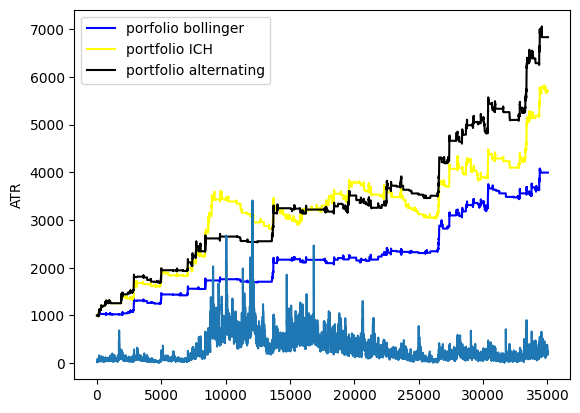

In [4540]:
plt.figure()
y = df['portfolio value bs']
x = df.index
# plt.ylabel('Portfolio Value Bollinger')
plt.plot(x,y, label = 'porfolio bollinger',color = 'blue')


y = df['portfolio value ich']
x = df.index
# plt.ylabel('Portfolio Value ICH')
plt.plot(x,y, label = 'portfolio ICH',color = 'yellow')


y = df['portfolio value']
x = df.index
# plt.ylabel('Portfolio Value Alternating')
plt.plot(x,y, label = 'portfolio alternating',color = 'black')

y_1 = df.ATR
# x = df.index
plt.ylabel('ATR')
plt.legend()
plt.plot(x,y_1)

In [4541]:
# # y = df['portfolio value'][20000:26000]
# x = df.index
# y_1 = df.HA_CLOSE
# # plt.plot(x,y)
# plt.plot(x,y_1)

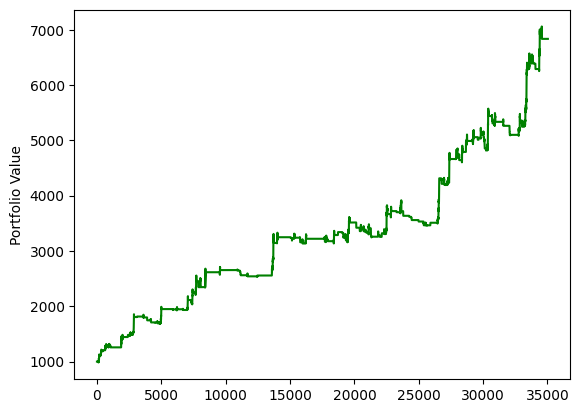

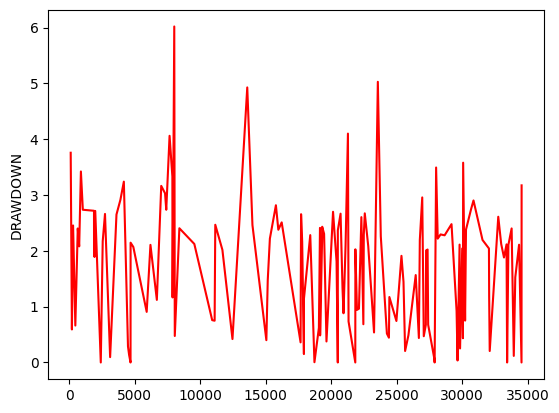

In [4542]:
plt.figure()
y = df['portfolio value']
x = df.index
plt.ylabel('Portfolio Value')
plt.plot(x,y, color = 'green')

plt.figure()
y = a_alter['drawdown']*100
x = a_alter['entry']
plt.ylabel('DRAWDOWN')
plt.plot(x,y, color = 'red')

In [4543]:
# a_alter

In [4544]:
# max_draw = 0
# for i in range(len(a_alter)):
#     draw = a_alter['drawdown'][i]*100
#     if(draw >= max_draw):
#         max_draw = draw
#         k = i
# max_draw, k

In [4545]:
# a_alter.iloc[k]

In [4546]:
# x = a_alter.entry[k] - 5
# y = a_alter.exit[k] + 5
# for i in range(x,y):
#     print("for i = ", i, "closing pricce is = ", df['close'][i])

In [4547]:
# i = a.entry[k]
# ads = df['signals_adx'][i]
# ms = df['signals_macd'][i]
# ichs_1 = df['signal_ich_1'][i]
# ichs_2 = df['signal_ich_2'][i]
# ichs_3 = df['signal_ich_3'][i]
# hms = df.signal_hma[i]
# slope = df['log slope'][i]

# ads, ms, ichs_1, ichs_2, ichs_3, hms, slope

In [4548]:
# count = 0
# for i in range(len(a)):
#     if(a['type'][i] == 'short'):
#         # count += a['P and L'][i]
#         print(a['drawdown'][i]*100)
# count

In [4549]:
lol = {
    'datetime': df['datetime'],
    'close': df['close'],
    'open': df['open'],
    'high': df['high'],
    'low': df['low'],
    'volume': df['volume'],
    'signals': df['alternating signal']
    }

In [4550]:
ddf = pd.DataFrame(lol)

In [4551]:
ddf.to_csv("output.csv")